# LGB_1 creation

Most of this is set up so that multiple models can be run, we run it just for
one day

## Packages & Preamble

We first load all packages: note that we ignore FutureWarning due to pyfolio

In [44]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
import optuna
from sklearn.preprocessing import OrdinalEncoder
from return_utils import pos_to_return,collecting_stock_data_avg,collecting_stock_percentages, factors_to_pos
import shap
import empyrical

import matplotlib.pyplot as plt



In [2]:
%load_ext autoreload
%autoreload 2

Load the list of tickers: note that we remove all appearing post 2017 to avoid
selection bias.

In [3]:
s_and_p = pd.read_csv('csvs/sp500/sp500_tickers.csv').iloc[:, 1]
s_and_p = list(s_and_p.map(
    lambda x: x.replace('\n', '')).values)
post_2017=['KDP','FOXA','ON','VICI','CPT','MOH','NDSN','CEG','SBNY','SEDG','FDS','EPAM','MTCH','CDAY','BRO','TECH','MRNA','OGN'
            ,'CRL','PTC','NXPI','PENN','GNRC','CZR','MPWR','TRMB','ENPH','TSLA','VNT','POOL','ETSY','TER','CTLT','BIO','TDY','TYL'
            ,'WST','DPZ','DXCM','OTIS','CARR','HWM','IR','PAYC','LYV',"ZBRA",'STE','ODFL','WRB','NOW','LVS','NVR','CDW','LDOS','IEX','TMUS'
            ,'MKTX','AMCRT','DD','CTVA','DOW','WAB','ATO','TFX','FRC','CE','LW','MXIM','FANG','JKHY','KEYS','FTNT','ROL','WCG','ANET','CPRT','FLT','BR'
            ,'HFC',"TWTR",'EVRG','ABMD','MSCI','TTWO','SIVB','NKTR','IPGP','HII','NCLH','CDNS','DWDP','SBAC','Q','BHF','DRE','AOS','PKG','RMD'
            ,'MGM','HLT','ALGN','ANSS','RE','INFO']
s_and_p=list(set(s_and_p)-set(post_2017))
post_2017=list(set(s_and_p)&set(post_2017))


Collect stock close and returns

In [4]:
stock_closes_df = collecting_stock_data_avg(tickers=s_and_p)
stock_closes_df.to_csv('csvs/sp500/collected_stock_closes.csv')
stock_closes_df.index=pd.to_datetime(stock_closes_df.index.values,format='%Y-%m-%d')

stock_volumes_df=collecting_stock_data_avg(tickers=s_and_p,value_name='Volume').mean(axis=1)
stock_volumes_df.to_csv('csvs/sp500/collected_stock_volumes.csv')
stock_volumes_df.index=pd.to_datetime(stock_closes_df.index.values,format='%Y-%m-%d')

stock_perc_df = collecting_stock_percentages(s_and_p)
stock_perc_df.index=pd.to_datetime(stock_perc_df.index.values,format='%Y-%m-%d')
stock_closes_rets_df=pd.concat([stock_closes_df,stock_perc_df],axis=1)
stock_closes_rets_df.to_csv('csvs/sp500/collected_stock closes_and_percentage_returns.csv')


Collect bnh returns only

In [5]:
bnh_returns_df=stock_perc_df.mean(axis=1)
bnh_returns_df.to_csv('csvs/sp500/bnh_returns.csv')

# MACHINE LEARNING STRATEGY

## Collect data

These are the topological factors

In [6]:
betti_values=pd.read_csv('Betti_experiments/Sharpe_values/betti_dim_3_points_5/relative_betti_values.csv',index_col='Date')
long_betti_values=pd.read_csv('Betti_experiments/Sharpe_values/betti_dim_3_points_9/relative_betti_values.csv',index_col='Date')
bmd_factors=pd.read_csv('Betti_experiments/Sharpe_values/relative_betti_dim_3_points_5/relative_meandiff_factors.csv',index_col='Date')
bmd_pos=factors_to_pos(stock_factor_df=bmd_factors,collected_stocks_df=stock_perc_df,tickers=s_and_p)

Run the below to make sure everything has datetime indices

In [7]:
bnh_returns_df.index=pd.to_datetime(bnh_returns_df.index.values,format='%Y-%m-%d')
for df in [long_betti_values,betti_values,bmd_factors,persist_factors]:
    df.index=pd.to_datetime(df.index.values,format='%Y-%m-%d')

The below function calculates wheter a stock is 'high' or 'low' in some
attribute, in reference to 'compar_ser'

In [462]:
def high_value(input_ser,compar_ser,output_ser):
    ind=compar_ser.index.intersection(input_ser.index)
    df=output_ser.loc[ind]
    input_ser=input_ser.loc[ind]
    compar_ser=compar_ser.loc[ind]
    (df
    .loc[
        input_ser.rolling(window=20).mean()
        >
        compar_ser.rolling(window=20).mean()
    ]       
    )=1
    (df
        .loc[input_ser.rolling(window=20).mean()
            <=
            compar_ser.rolling(window=20).mean()
            ]       
    )=0

    df.loc[df.isnull()&(input_ser>compar_ser)]=1
    df.loc[df.isnull()&(input_ser<compar_ser)]=0
    return df.shift(1)



Set indexers, and call a few dataframes

In [8]:
future_window=5
long_fut=10
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=future_window)
long_indexer=pd.api.indexers.FixedForwardWindowIndexer(window_size=long_fut)
bnh_returns_df.index=pd.to_datetime(bnh_returns_df.index.values,format='%Y-%m-%d')
bns=bnh_returns_df.rolling(window=future_window).sum()
bnm=bnh_returns_df.rolling(window=future_window).mean()
bnstd=bnh_returns_df.rolling(window=future_window).std()
mean_stocks=stock_closes_df.mean(axis=1)
mean_stocks.index=pd.to_datetime(mean_stocks.index.values,'%Y-%m-%d')




Loop over stocks and calculate various attributes

In [464]:

for t in tqdm(s_and_p):
    df=pd.read_csv('Persim_vs_Betti/sp500/landscape/{stock}.csv',index_col='Date')
    df.index=pd.to_datetime(df.index.values,format='%Y-%m-%d')


    df.loc[:,'test']=np.nan
    df.loc[:,'High value']=high_value(df.loc[:,'Adj Close'],mean_stocks,df.loc[:,'test'])
    df.loc[:,'High volume']=high_value(df.loc[:,'Volume'],stock_volumes_df,df.loc[:,'test'])
    df['Price momentum']=df['Adj Close'].rolling(window=20).mean()/df['Adj Close'].rolling(window=60).mean()
    df['Landscape values']=df['Persistence landscape norm']

    df=df.loc[:,['Price momentum', 'Landscape values','High value','High volume']]

    df['ticker']=t
    df['Returns']=stock_perc_df[t +' % Return']
    df['Betti values dim=3 points=5']=betti_values[t]
    df['Betti values dim=3 points=9']=long_betti_values[t]

    df['Relative return']=(df['Returns']-bnh_returns_df)
    df['Relative return momentum']=(df['Relative return'].rolling(window=10).mean()/df['Relative return'].rolling(window=30).mean())
    df['Return momentum']=(df['Returns'].rolling(window=10).mean()/df['Returns'].rolling(window=30).mean())
    df['Betti momentum']=(df['Betti values dim=2 points=5']/df['Betti values dim=2 points=9'])
    df['Betti meandiff']=bmd_factors[t]
    # df['Betti meandiff strategy position']=bmd_pos[f'{t} Position']
    df['Landscape mean diff']=(df['Landscape values']-df['Landscape values'].rolling(window=21).mean())
    df[f'{long_fut} day past relative return']=df[f'Relative return'].rolling(window=long_fut).mean()
    df[f'{future_window} day past relative return']=df[f'Relative return'].rolling(window=future_window).mean()
    df[f'{long_fut} day future relative return']=df[f'Relative return'].shift(-1).rolling(window=long_indexer).mean()
    df[f'{future_window} day future relative return']=df[f'Relative return'].shift(-1).rolling(window=indexer).mean()
    df['1 day future relative return']=df[f'Relative return'].shift(-1)
    df.index.name='Date'
    df.to_csv('ML_experiments/ML_dataframes/'+t+'.csv')


100%|██████████| 410/410 [00:52<00:00,  7.85it/s]


Create test etc data

In [9]:
fit_data=pd.DataFrame(dtype=np.float64)
valid_data=pd.DataFrame(dtype=np.float64)
test_data=pd.DataFrame(dtype=np.float64)
train_data=pd.DataFrame(dtype=np.float64)

Below sets start/end dates for fit, validation, training (=fit + validation),
and test

In [10]:
dates={'fit_start':'2017-08-11','fit_end':'2018-07-02', 'valid_start':'2018-07-24',
'valid_end':'2019-01-02', 'train_start':'2017-08-11',
'train_end':'2019-01-02','test_start':'2019-01-24', 'test_end': '2022-05-30'}
d_splits=['fit','valid','train','test']
data_split_dfs={'fit':fit_data,'valid':valid_data,'train':train_data,'test':test_data}

### Run below first time only

Create fit/validation/training/test data

In [467]:
for sp in d_splits:
        data_split_dfs[sp]=pd.DataFrame(dtype=np.float64)
        for t in s_and_p:
            df=pd.read_csv('ML_experiments/ML_dataframes/'+t+'.csv',index_col='Date')
            df.index=pd.to_datetime(df.index.values,format='%Y-%m-%d')
            df.index=df.index.rename('Date')
            df=df.loc[dates[sp+'_start']:dates[sp+'_end']]
            data_split_dfs[sp]=pd.concat([data_split_dfs[sp],df])
        data_split_dfs[sp].to_csv('ML_experiments/ML_'+sp+'.csv')

### Run second time

In [11]:
fit_data=pd.read_csv('ML_experiments/ML_fit.csv', low_memory=False,index_col='Date')
valid_data=pd.read_csv('ML_experiments/ML_valid.csv', low_memory=False,index_col='Date')
test_data=pd.read_csv('ML_experiments/ML_test.csv', low_memory=False,index_col='Date')
train_data=pd.read_csv('ML_experiments/ML_train.csv',low_memory=False,index_col='Date')
for df in [fit_data,valid_data,test_data]:
        df.index=pd.to_datetime(df.index.values,format='%Y-%m-%d')

### Finish collecting data

We use the below in model construction

In [12]:
oe=OrdinalEncoder()
drops=['ticker','1 day future relative return',
        f'{future_window} day future relative return',f'{long_fut} day future relative return']
X_fit=fit_data.copy()
X_fit.index.name='Date'
X_test=test_data.copy()
X_test.index.name='Date'
X_valid=valid_data.copy()
X_valid.index.name='Date'
X_train=train_data.copy()
X_train.index.name='Date'
for df in [X_fit,X_valid,X_test,X_train]:
    df.drop(drops, axis=1,inplace=True)

Create target variables. Note that we keep model names and use dictionaries to
define target variables, models, etc, so can add/remove models easily

In [15]:


y_next_fit = fit_data.copy()[['1 day future relative return']]
y_next_valid = valid_data.copy()[['1 day future relative return']]
y_next_test = test_data.copy()[['1 day future relative return']]
y_next_train = train_data.copy()[['1 day future relative return']]


model_names=['lgb_1']

predict_data={'lgb_1':[y_next_fit,y_next_valid,y_next_train,y_next_test]      
        }
time_scale={'lgb_1':1}

for mod in model_names:
    for i in range(4):
        predict_data[mod][i].index.name='Date'
        predict_data[mod][i]=( predict_data[mod][i][f'{time_scale[mod]} day future relative return']> 0)*1
      
             



## Optimize model params

Use Optuna to optimize model parameters

In [38]:
def objective(trial, modeller,X, y,Xv,yv):
    param_grid = {
        #         "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [1000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=10),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 100, 10000, step=50),
        "max_bin": trial.suggest_int("max_bin", 100, 300),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=1),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=1),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.05
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.05
        ),
    }
    model = modeller()
    model.fit(
            X,
            y
    )
    # preds = model.predict(Xv)
    return (model.score(Xv,yv))

In [13]:
lgb_1_ret = lgb.LGBMClassifier()

model_name_dict={'lgb_1':lgb_1_ret
                }

In [40]:
optuna.logging.set_verbosity(0)
best_param_dict={}
for mod in model_names:
    study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
    Xm=X_fit.reset_index().drop('Date',axis=1)
    ym=predict_data[mod][0].reset_index().drop('Date',axis=1)
    Xmv=X_valid.reset_index().drop('Date',axis=1)
    ymv=predict_data[mod][1].reset_index().drop('Date',axis=1)

    func = lambda trial: objective(trial, lgb.LGBMClassifier,Xm,ym.iloc[:,0].ravel(),Xmv,ymv.iloc[:,0].ravel())
    study.optimize(func, n_trials=20)
    best_param_dict[mod]=pd.DataFrame(study.best_params.items(),columns=['params','value'])
    model_name_dict[mod]=lgb.LGBMClassifier(**study.best_params)
    model_name_dict[mod].fit(X_train.reset_index().drop('Date',axis=1),predict_data[mod][2].reset_index().drop('Date',axis=1).iloc[:,0].ravel())
    print(f'{mod} fitted')
    # model_name_dict[mod].booster_.save_model('ML_experiments/models/'+mod+'_lgb_model.txt')


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=8500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8500
[LightGBM] [Warning] lambda_l2 is set=99, reg_lambda=0.0 will be ignored. Current value: lambda_l2=99
[LightGBM] [Warning] feature_fraction is set=0.8500000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8500000000000001
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] min_gain_to_split is set=11.843578428245749, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.843578428245749
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
lgb_one_day fitted


## Predict and evaluate

In [17]:
test_data=test_data.loc[dates['test_start']:dates['test_end']]

In [61]:
rets_dict={}
pos_dict={}
performance_stats_ml=pd.DataFrame(dtype=np.float64)
for mod in model_names:
    final_pos=stock_closes_rets_df.copy().loc[dates['test_start']:dates['test_end']]
    pos=pd.DataFrame(dtype=np.float64)
    for t in s_and_p:
        df=test_data.loc[test_data['ticker']==t]
        df=df.drop(drops,axis=1)
        y_pred=model_name_dict[mod].predict(df)
        y_pred=(
            pd.DataFrame(y_pred,index=df.index.values,columns=[t+' Position'])
            .shift(1)
        )
        pos=pd.concat([pos,y_pred],axis=1)
    pos.replace(0,np.nan,inplace=True)
    final_pos=pd.concat([pos,final_pos],axis=1)
    pos_dict[mod]=final_pos
    print(f'{mod} positions calculated')
    rets=pos_to_return(final_pos, tickers=s_and_p, start=dates['test_start'], end=dates['test_end'],  hold_len=1)
    rets_dict[mod]=rets
    print(f'{mod} returns calculated')
    perf_values=pd.DataFrame({
        'Sharpe':empyrical.sharpe_ratio(rets),
        'Sortino':empyrical.sortino_ratio(rets),
        'alpha':empyrical.alpha(rets,bnh_returns_df),
        'beta':empyrical.beta(rets,bnh_returns_df)
    },index=[f'{mod}'])
    performance_stats_ml=pd.concat([performance_stats_ml,perf_values])

lgb_one_day positions calculated
lgb_one_day returns calculated


In [63]:
bnh_perf=pd.DataFrame({
        'Sharpe':empyrical.sharpe_ratio(bnh_returns_df.loc[dates['test_start']: dates['test_end']]),
        'Sortino':empyrical.sortino_ratio(bnh_returns_df.loc[dates['test_start']: dates['test_end']]),
        'alpha':'-',
        'beta':'-'
    },index=['bnh'])
bnh_perf.to_csv('ML_experiments/Sharpe_vals/bnh_performance.csv')

In [64]:
performance_stats_for_csv=pd.concat([performance_stats_ml,bnh_perf])
performance_stats_for_csv.index.name='Strategy'

print(performance_stats_for_csv)

                           Sharpe   Sortino     alpha     beta
Strategy                                                      
lgb_one_day, hold len=1  0.867406  1.200277  0.016483  1.03067
bnh                      0.817187  1.136360         -        -


## Shap values

In [64]:
X_shaps=X_train.sample(n=10000,random_state=31415)

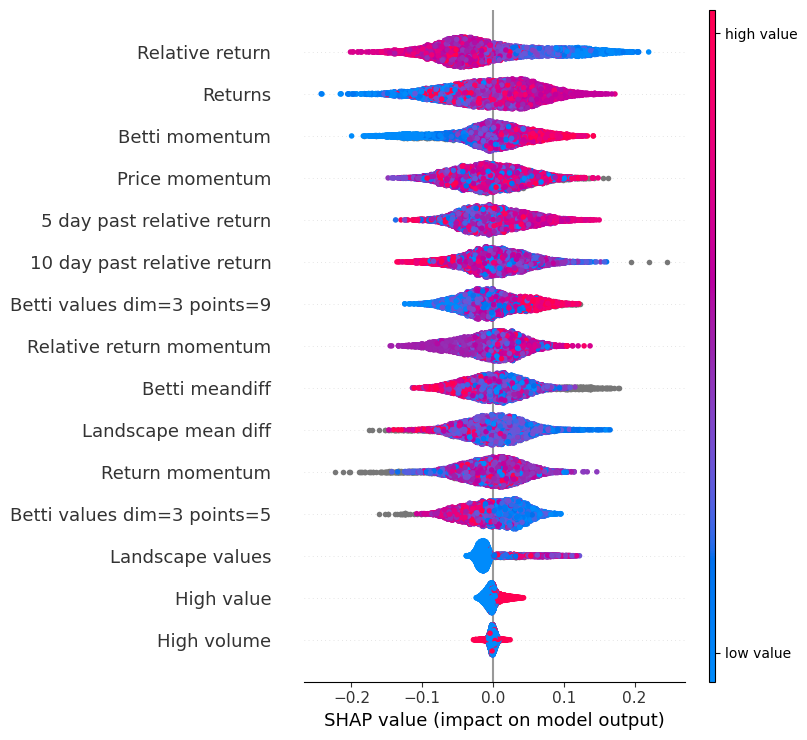

In [74]:
model=lgb.Booster(model_file=f'ML_experiments/Models/final_lgb_1_model.txt')
model.params['objective']='binary'
lgb_exp = shap.Explainer(model,X_shaps)
shap_values=lgb_exp(X_shaps)
shap.summary_plot(shap_values,features=X_shaps,show=False,color_bar=False)
cbar=plt.colorbar(aspect=100)
cbar.set_ticks([-0.0175,0.0175])
cbar.set_ticklabels(['low value','high value'])
plt.show()

# Options to save model outcomes etc

In [ ]:
save=False

In [39]:
if save==True:
    model_names=['lgb_1']
    for mod in model_names:
        best_param_dict[mod].to_csv(f'ML_experiments/Models/final_{mod}_params.csv')
        model_name_dict[mod].booster_.save_model(f'ML_experiments/Models/final_{mod}_model.txt')
        rets_dict[mod].to_csv(f'ML_experiments/Models/final_{mod}_returns.csv')
        pos_dict[mod].to_csv(f'ML_experiments/Models/final_{mod}_ret_pos.csv')
    performance_stats_for_csv.to_csv(f'ML_experiments/Sharpe_vals/{mod} performance stats.csv')